In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [49]:
def prepare_dataset(data):
    data.sort_values('Date', inplace=True)
    data["opinion_integer"] = 0
    data.loc[data['Opinion'] == '-', "opinion_integer"] = 0
    data.loc[data['Opinion'] == 'o', "opinion_integer"] = 1
    data.loc[data['Opinion'] == '+', "opinion_integer"] = 2

In [60]:
data_actual = pd.read_csv('../protocols/labelled/massnahmen_relevant.csv', sep='\t')
prepare_dataset(data_actual)
dates = data_actual['Date'].unique()
parties = data_actual['Party'].unique()
speakers = data_actual['speaker_name'].unique()
speakers.sort()
speaker_party = {speaker: data_actual[data_actual['speaker_name'] == speaker]['Party'].tolist()[0] for speaker in speakers}

In [51]:
data_pred = pd.read_csv('../protocols/labelled/massnahmen_relevant_bert_predictions.csv', sep='\t')
prepare_dataset(data_pred)

In [52]:
def get_opinion_consistencies(data, entity_col_name, entities, include_neut=False):
    opinions_per_entity_day = {entity: [] for entity in entities}
    for date in dates:
        data_day = data[data['Date'] == date]
    
        for entity in entities:
            data_day_entity = data_day[data_day[entity_col_name] == entity]
            opinion_counts = np.bincount(data_day_entity['opinion_integer'], minlength=3)
            opinions_per_entity_day[entity].append(opinion_counts)
    
    opinion_consistency_per_entity = {entity: [] for entity in entities}
    for entity in entities:
        opinions_per_day = opinions_per_entity_day[entity]
        cumulative_opinions = np.array([0,0,0])
        opinion_consistencies = []
        for opinions in opinions_per_day:
            cumulative_opinions += opinions
            if include_neut:
                opinion_consistency = (cumulative_opinions[[0,2]].max() + cumulative_opinions[1]) / cumulative_opinions[[0,1,2]].sum()
            else:
                opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()
            opinion_consistencies.append(opinion_consistency)
        opinion_consistency_per_entity[entity] = opinion_consistencies
    return opinion_consistency_per_entity

In [53]:
selected_parties = ['SPÖ', 'ÖVP', 'FPÖ', 'NEOS', 'Grüne', 'ohne Klubzugehörigkeit']
op_cons_parties_actual = get_opinion_consistencies(data_actual, 'Party', selected_parties)
op_cons_parties_pred = get_opinion_consistencies(data_pred, 'Party', selected_parties)
op_cons_parties_actual_with_neut = get_opinion_consistencies(data_actual, 'Party', selected_parties, True)
op_cons_parties_pred_with_neut = get_opinion_consistencies(data_pred, 'Party', selected_parties, True)
selected_speakers = ['Rudolf Anschober', 'Gerald Loacker', 'Herbert Kickl', 'Gerhard Kaniak', 'Pamela Rendi-Wagner', 'Sebastian Kurz']
op_cons_speakers_actual = get_opinion_consistencies(data_actual, 'speaker_name', selected_speakers)
op_cons_speakers_pred = get_opinion_consistencies(data_pred, 'speaker_name', selected_speakers)
op_cons_speakers_actual_with_neut = get_opinion_consistencies(data_actual, 'speaker_name', selected_speakers, True)
op_cons_speakers_pred_with_neut = get_opinion_consistencies(data_pred, 'speaker_name', selected_speakers, True)

<ipython-input-52-c895eb336caf>:21: RuntimeWarning: invalid value encountered in long_scalars
  opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()
<ipython-input-52-c895eb336caf>:19: RuntimeWarning: invalid value encountered in long_scalars
  opinion_consistency = (cumulative_opinions[[0,2]].max() + cumulative_opinions[1]) / cumulative_opinions[[0,1,2]].sum()


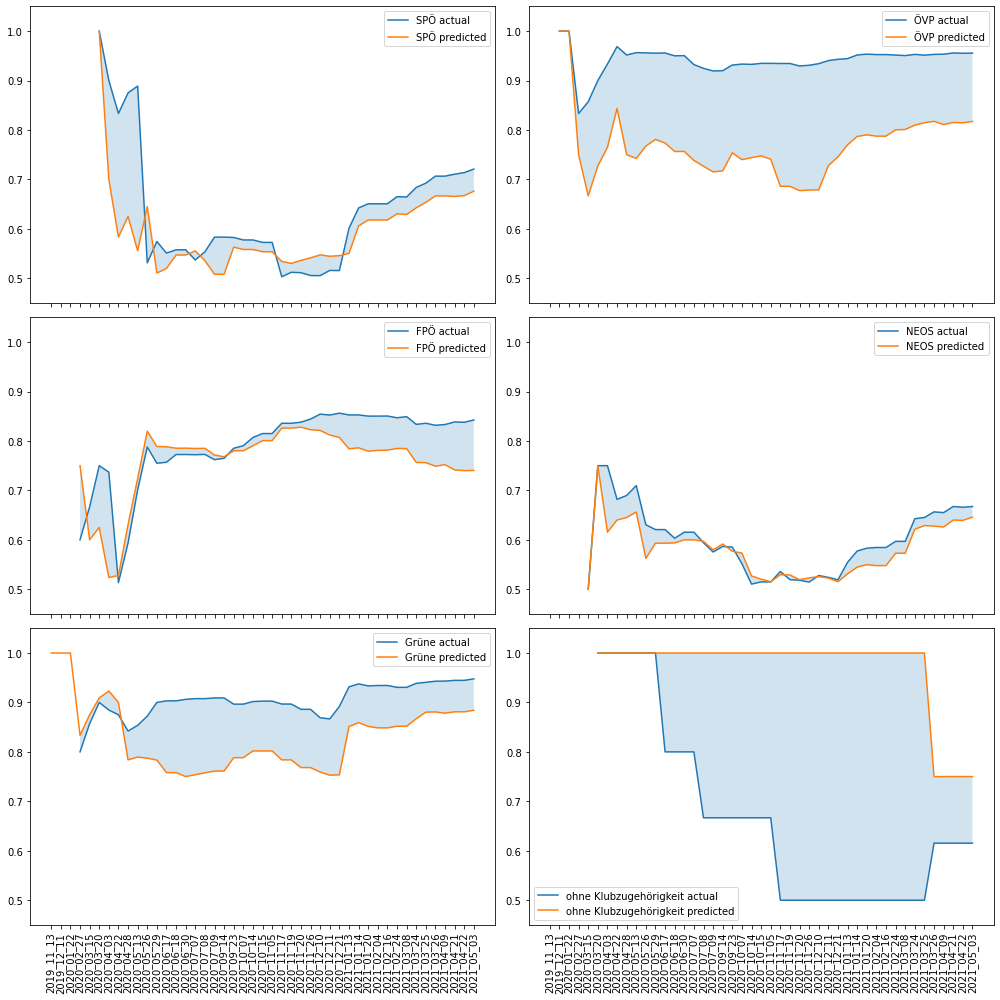

In [54]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(14, 14))

for i, party in enumerate(selected_parties):
    a = int(i / 2)
    b = i % 2
    ax[a, b].plot(dates, op_cons_parties_actual[party], label=f'{party} actual')
    ax[a, b].plot(dates, op_cons_parties_pred[party], label=f'{party} predicted')
    ax[a, b].fill_between(dates, op_cons_parties_actual[party], op_cons_parties_pred[party], alpha=0.2)
    ax[a, b].set_ylim(0.45, 1.05)
    ax[a, b].set_xticks(dates)
    ax[a, b].set_xticklabels(dates, rotation='vertical')
    ax[a, b].legend()

fig.tight_layout()
fig.savefig('../results/opinion_measures_comparison_party.png')

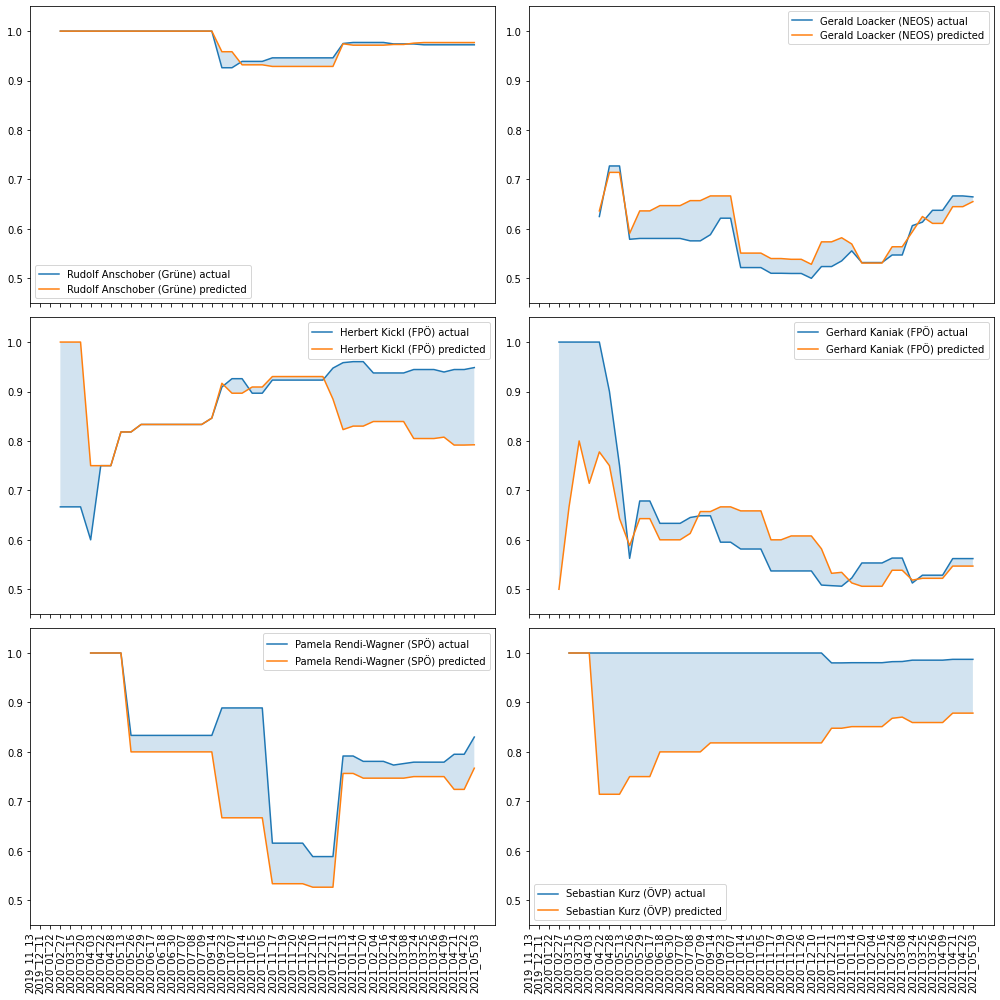

In [61]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(14, 14))

for i, speaker in enumerate(selected_speakers):
    a = int(i / 2)
    b = i % 2
    speaker_label = f'{speaker} ({speaker_party[speaker]})'
    ax[a, b].plot(dates, op_cons_speakers_actual[speaker], label=f'{speaker_label} actual')
    ax[a, b].plot(dates, op_cons_speakers_pred[speaker], label=f'{speaker_label} predicted')
    ax[a, b].fill_between(dates, op_cons_speakers_actual[speaker], op_cons_speakers_pred[speaker], alpha=0.2)
    ax[a, b].set_ylim(0.45, 1.05)
    ax[a, b].set_xticks(dates)
    ax[a, b].set_xticklabels(dates, rotation='vertical')
    ax[a, b].legend()

fig.tight_layout()
fig.savefig('../results/opinion_measures_comparison_speaker.png')

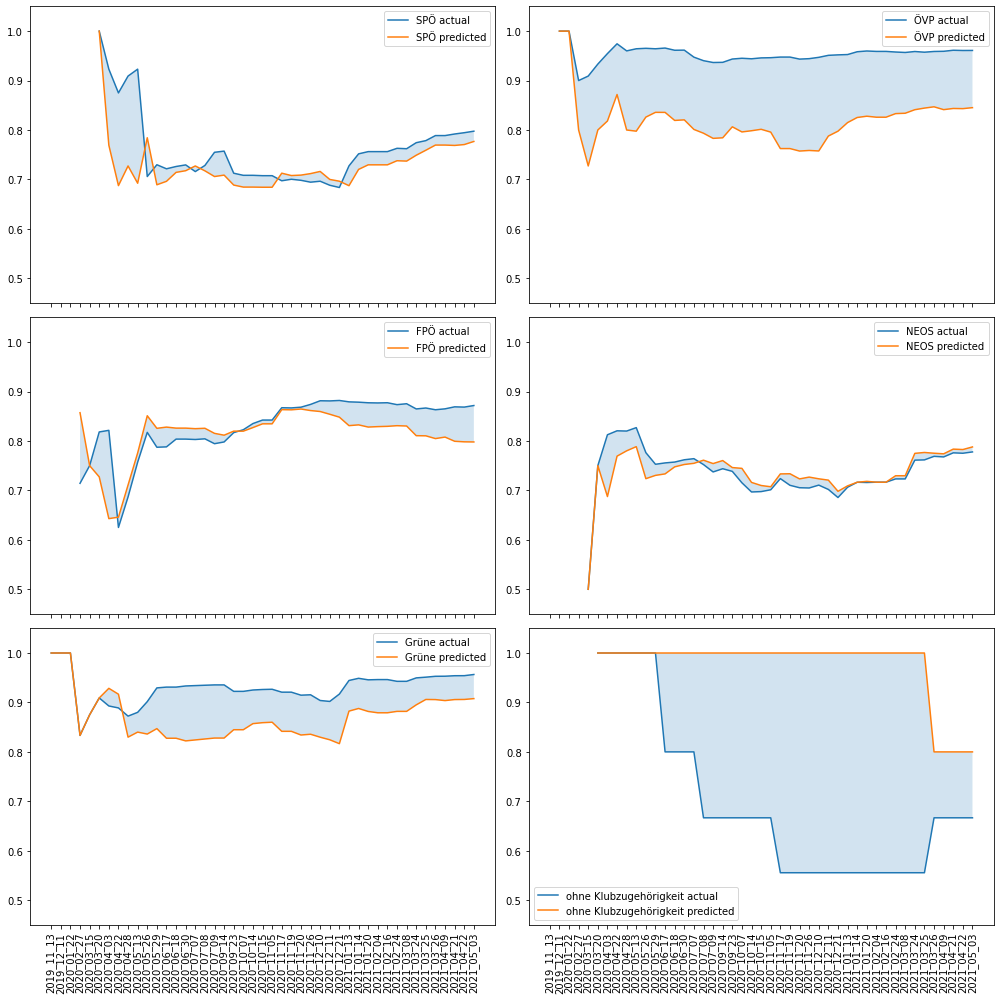

In [56]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(14, 14))

for i, party in enumerate(selected_parties):
    a = int(i / 2)
    b = i % 2
    ax[a, b].plot(dates, op_cons_parties_actual_with_neut[party], label=f'{party} actual')
    ax[a, b].plot(dates, op_cons_parties_pred_with_neut[party], label=f'{party} predicted')
    ax[a, b].fill_between(dates, op_cons_parties_actual_with_neut[party], op_cons_parties_pred_with_neut[party], alpha=0.2)
    ax[a, b].set_ylim(0.45, 1.05)
    ax[a, b].set_xticks(dates)
    ax[a, b].set_xticklabels(dates, rotation='vertical')
    ax[a, b].legend()

fig.tight_layout()
fig.savefig('../results/opinion_measures_comparison_party_with_neut.png')

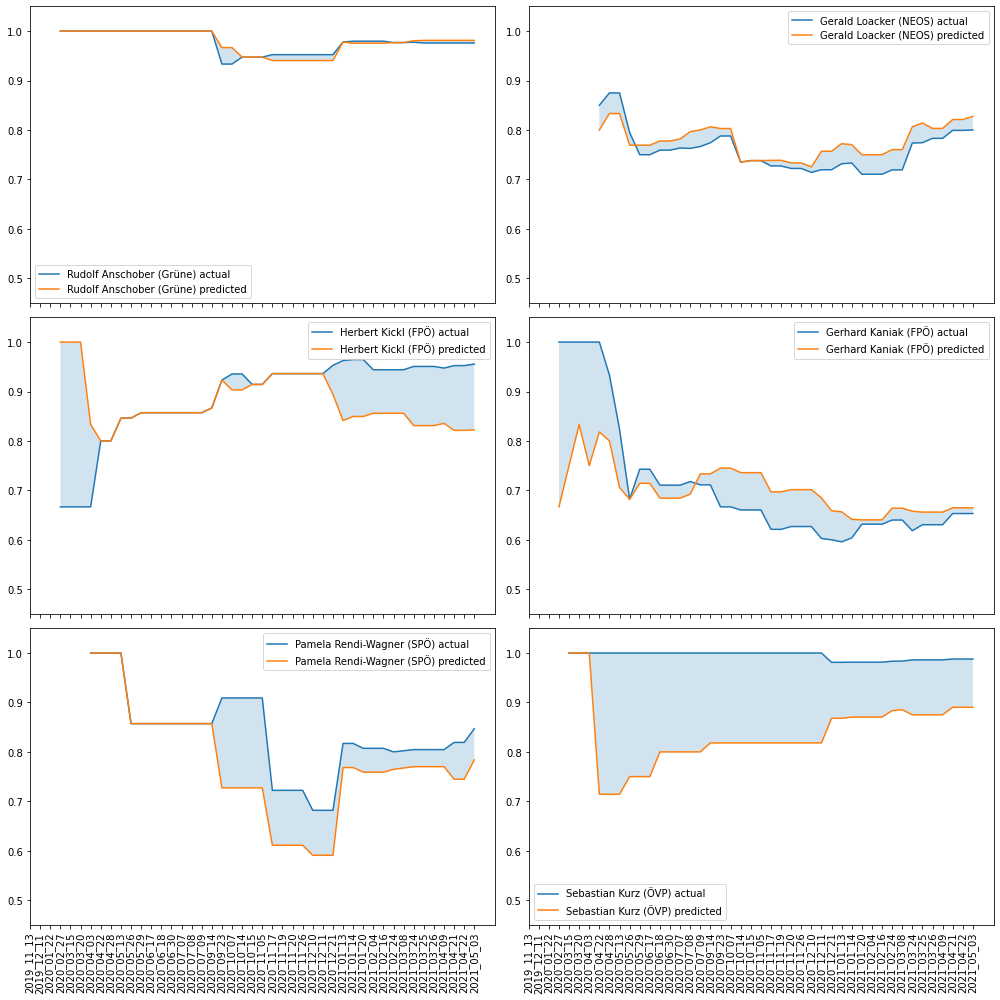

In [62]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(14, 14))

for i, speaker in enumerate(selected_speakers):
    a = int(i / 2)
    b = i % 2
    speaker_label = f'{speaker} ({speaker_party[speaker]})'
    ax[a, b].plot(dates, op_cons_speakers_actual_with_neut[speaker], label=f'{speaker_label} actual')
    ax[a, b].plot(dates, op_cons_speakers_pred_with_neut[speaker], label=f'{speaker_label} predicted')
    ax[a, b].fill_between(dates, op_cons_speakers_actual_with_neut[speaker], op_cons_speakers_pred_with_neut[speaker], alpha=0.2)
    ax[a, b].set_ylim(0.45, 1.05)
    ax[a, b].set_xticks(dates)
    ax[a, b].set_xticklabels(dates, rotation='vertical')
    ax[a, b].legend()

fig.tight_layout()
fig.savefig('../results/opinion_measures_comparison_speaker_with_neut.png')

